# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

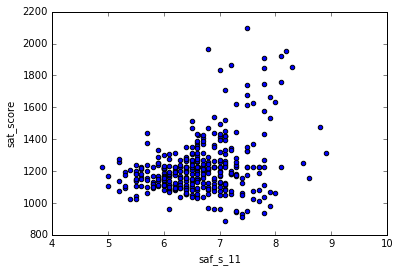

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.plot.scatter(x='saf_s_11',y='sat_score')
plt.show()

The correlation between the sat scores and the students' satisfaction of the school is positive, not really strong bu not even weak or absent. It pretty much represents a broad line that goes from (6,1000) to (8.5-2000). It appears that a lot of points are included in the ranges saf_s_11:[5.5-7.5] and sat_score:[1000-1500]. It could be worth it to analyze more deeply the data set in this specific ranges of values.

In [13]:
sat_sat_st=combined[(combined['sat_score']>1000) & (combined['sat_score']<1500) & (combined['saf_s_11']>5.5) & (combined['saf_s_11']<7.5)]
#sat_sat_st

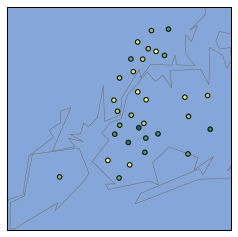

In [14]:
# Plotting "students' satisfaction by NY districts"
# The following plot shows what's the students's satisfaction
# of their school in every district of NY city.

grouped_districts=combined.groupby('school_dist').agg(numpy.mean)
grouped_districts.reset_index(inplace=True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=grouped_districts['lon'].tolist()
latitudes=grouped_districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True,c=grouped_districts['saf_s_11'],cmap='summer')
plt.show()

In [116]:
grouped_districts=grouped_districts.sort_values('sat_score')


,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per,sat_av
11,12,364.769900,379.109453,357.943781,1101.823134,93.102564,139.442308,153.450000,110.467742,12.0,...,10463.166667,409.000000,1.083333,0.0,0.0,0.0,40.831412,-73.886946,0.265387,7.677778
18,19,367.083333,377.583333,359.166667,1103.833333,88.097756,124.769231,120.670833,114.322581,19.0,...,11207.500000,440.416667,1.916667,0.0,0.0,0.0,40.676547,-73.882158,0.200646,6.752778
17,18,373.454545,373.090909,371.454545,1118.000000,129.028846,197.038462,153.450000,72.771261,18.0,...,11224.000000,344.000000,1.090909,0.0,0.0,0.0,40.641863,-73.914726,0.396711,7.118182
31,32,371.500000,385.833333,362.166667,1119.500000,70.342949,100.179487,83.558333,105.333333,32.0,...,11231.666667,381.500000,1.000000,0.0,0.0,0.0,40.696295,-73.917124,0.170409,7.388889
15,16,371.529851,379.164179,369.415672,1120.109701,82.264423,126.519231,153.450000,247.185484,16.0,...,11219.000000,440.250000,1.750000,0.0,0.0,0.0,40.688008,-73.929686,0.309973,6.333333
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971,0.170719,7.397436
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240,0.175797,7.366667
22,23,380.666667,398.666667,378.000000,1157.333333,29.000000,31.000000,153.450000,87.000000,23.0,...,11219.000000,391.000000,1.333333,0.0,0.0,0.0,40.668586,-73.912298,0.063672,7.055556
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087,0.249342,7.215505
16,17,386.571429,394.071429,380.785714,1161.428571,105.583791,163.087912,111.360714,121.357143,17.0,...,11220.642857,547.071429,1.642857,0.0,0.0,0.0,40.660313,-73.955636,0.209731,6.933333


From the plot above it seems that the majority of the schools with a high students' satisfaction is in Manhattan and in Queens, while Brooklyn is the district with the least satisfied students.
Strangely enough the Bronx has pretty satisfied students too.

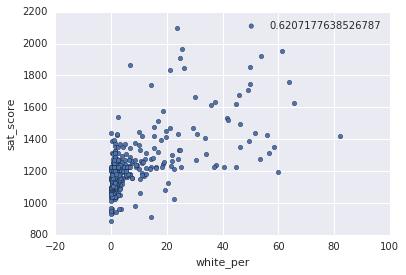

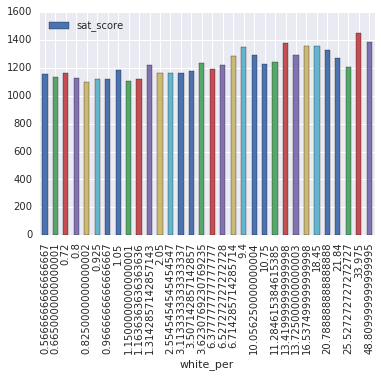

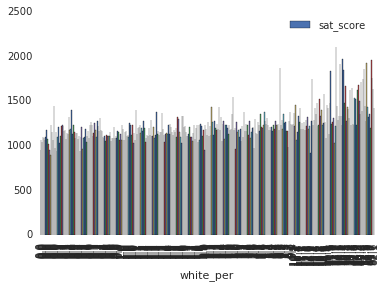

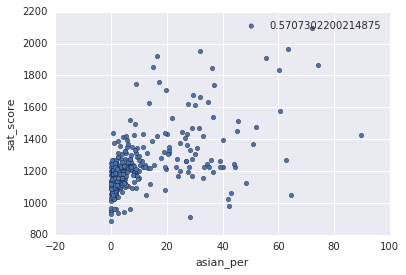

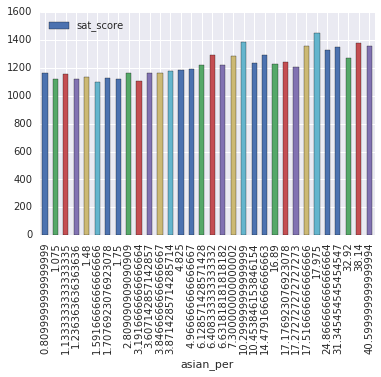

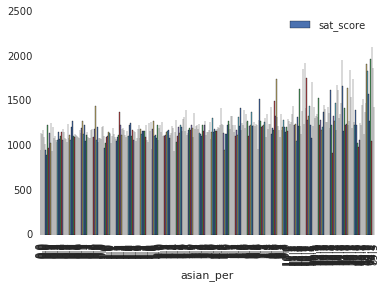

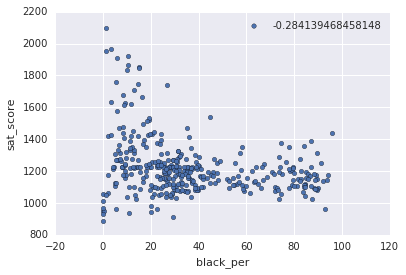

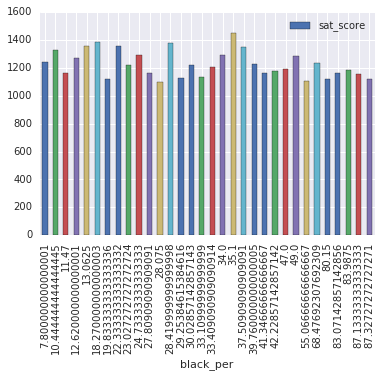

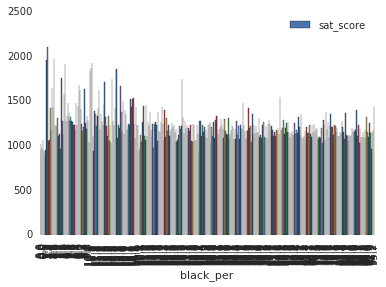

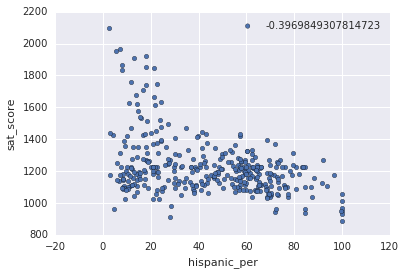

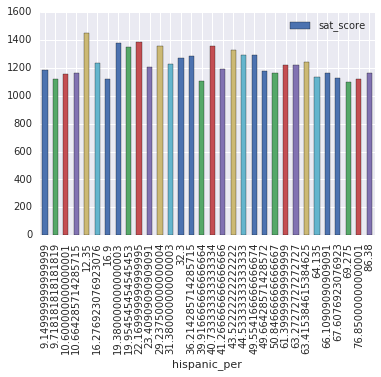

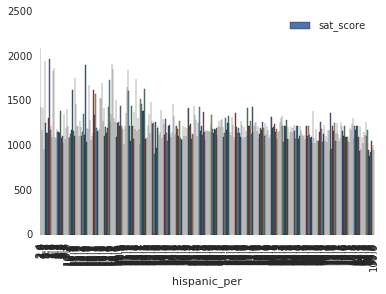

In [117]:
import seaborn as sns

combined.plot.scatter(x='white_per', y='sat_score',label=correlations['white_per'])
grouped_districts=grouped_districts.sort_values('white_per')
grouped_districts.plot.bar(x='white_per',y='sat_score')
combined=combined.sort_values('white_per')
combined.plot.bar(x='white_per',y='sat_score')


combined.plot.scatter(x='asian_per', y='sat_score',label=correlations['asian_per'])
grouped_districts=grouped_districts.sort_values('asian_per')
grouped_districts.plot.bar(x='asian_per',y='sat_score')
combined=combined.sort_values('asian_per')
combined.plot.bar(x='asian_per',y='sat_score')

combined.plot.scatter(x='black_per', y='sat_score',label=correlations['black_per'])
grouped_districts=grouped_districts.sort_values('black_per')
grouped_districts.plot.bar(x='black_per',y='sat_score')
combined=combined.sort_values('black_per')
combined.plot.bar(x='black_per',y='sat_score')

combined.plot.scatter(x='hispanic_per', y='sat_score',label=correlations['hispanic_per'])
grouped_districts=grouped_districts.sort_values('hispanic_per')
grouped_districts.plot.bar(x='hispanic_per',y='sat_score')
combined=combined.sort_values('hispanic_per')
combined.plot.bar(x='hispanic_per',y='sat_score')

plt.show()


Well, it is pretty evident (as the Pearson's coefficient also showed) that we have a positive correlation (a strong one for low scores and a weaker one for high scores) between the sat_score and the percentage of whites and asians (resp. 0.62 and 0.57); whereas we do have negative weak and medium correlations (-0.28 and -0.39) between the sat_score and the percentage of, respectively, blacks and hispanics.
It is also noticeable, from the bar plots, that white people and asian people tend to have better scores if their percentage increases; while, on the contrary black people tend to have slightly better scores if their percentage is below 37%
The hispanic case is a peculiar one. Spanish speaking people tend to get, infact, higher scores if their percentage is included in the range 12-50%. Outside of this range their scores are evidently lower.

In [84]:
hisp_maj=combined[combined['hispanic_per']>95.0]
hisp_maj['SCHOOL NAME'].describe()

count                             8
unique                            8
top       MULTICULTURAL HIGH SCHOOL
freq                              1
Name: SCHOOL NAME, dtype: object

In [21]:
hisp_min=combined[combined['hispanic_per']<10.0]
hisp_min['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

Schools where the hispanic community has a number of students exceeding 95% are schools specifically addressed to spanish speaking immigrants and there are just 8 in all the NY area.
Schools were the hispanic community has a number of students below 10% are 30 in the NY area and those are mainly science and technology schools.

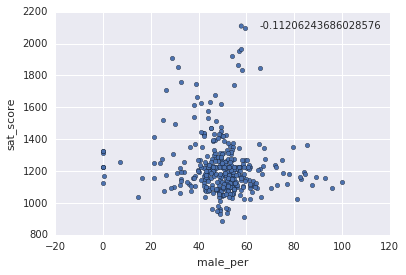

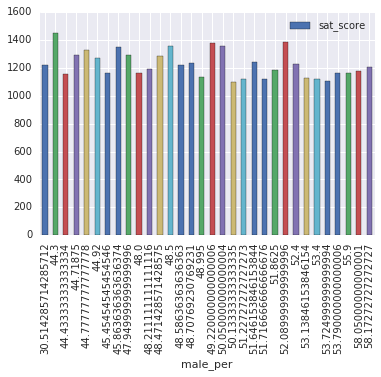

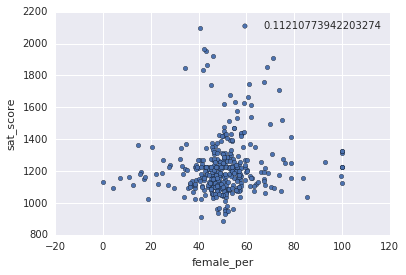

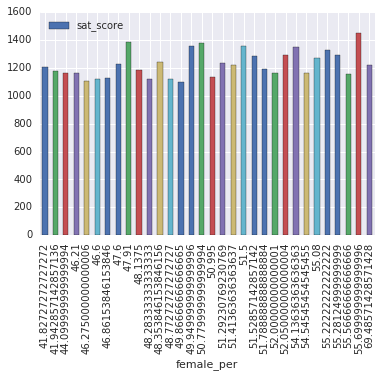

   school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
20          21                       395.283582           421.786974   
13          14                       395.937100           398.189765   
10          11                       389.866667           394.533333   
5           06                       382.011940           400.565672   
18          19                       367.083333           377.583333   
15          16                       371.529851           379.164179   
6           07                       376.461538           380.461538   
26          27                       407.800000           422.200000   
30          31                       457.500000           472.500000   
28          29                       395.764925           399.457090   
31          32                       371.500000           385.833333   
23          24                       405.846154           434.000000   
17          18                       373.454545           373.09

In [118]:
combined.plot.scatter(y='sat_score',x='male_per', label=correlations['male_per'])
grouped_districts=grouped_districts.sort_values('male_per')
grouped_districts.plot.bar(x='male_per',y='sat_score')
combined.plot.scatter(y='sat_score',x='female_per', label=correlations['female_per'])
grouped_districts=grouped_districts.sort_values('female_per')
grouped_districts.plot.bar(x='female_per',y='sat_score')
plt.show()
print(grouped_districts)

From the scatter plots it appears that there are weak correlations between the sat scores and the percentages of boys/girls in schools. In particular guys seem to get lower sat scores as their number increases, which testifies a negative weak correlation (-0.11), whereas girls have better scores as their number increases, showing thus a weak positive correlation (0.11). These trends are confirmed by the bar plots.

26                         ELEANOR ROOSEVELT HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
5                         BARD HIGH SCHOOL EARLY COLLEGE
60                                    BEACON HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


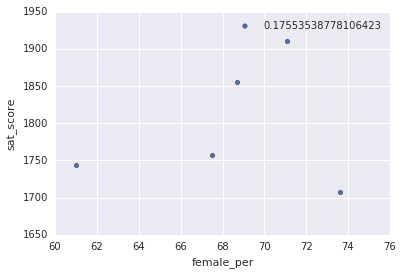

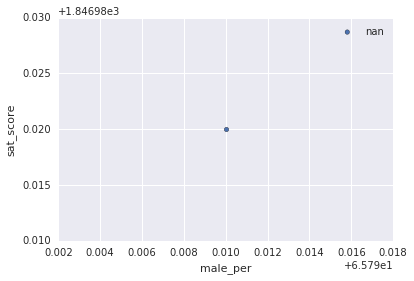

In [86]:


hig_fem_sco=combined[(combined['female_per']>60.0)&(combined['sat_score']>1700)]
correl=hig_fem_sco.corr()
correl=correl["sat_score"]
hig_fem_sco.plot.scatter(x='female_per',y='sat_score', label=correl['female_per'])
print(hig_fem_sco['SCHOOL NAME'])

hig_mas_sco=combined[(combined['male_per']>60.0)&(combined['sat_score']>1700)]
correl_m=hig_mas_sco.corr()
correl_m=correl_m["sat_score"]
hig_mas_sco.plot.scatter(x='male_per',y='sat_score', label=correl_m['male_per'])

As we can see from the scatter plot, the correlation between high scores and high percentages of females is definitely weak positive, even if we just have five markers on our plot.
The schools were we there results occurred are public schools mainly located in Manhattan.

We tried to plot the same correlation for males and it appears that there's just one case (that's why r=NaN) where males are more than 60% and have a score higher than 1700. It definitely seems confirmed the stereotype that girls are better students.



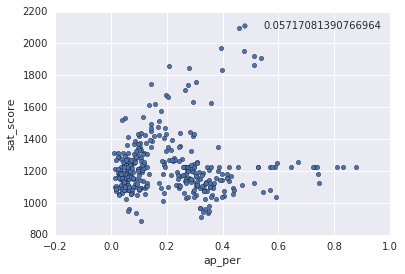

In [91]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score',label=correlations['ap_per'])
plt.show()

Well, the scatter plot between the percentage of ap test takers and the sat score shows a very peculiar trend. In spite of the fact that these two parameters have a Pearson's coefficient=0.05 which testifies a very weak and positive correlation, from the plot it seems that there are two different trends. One clearly positive and pretty strong and one that seems to be neutral, almost an horizontal line, in the sense that as the percentage of ap test takers increases, the sat scores remain the same.

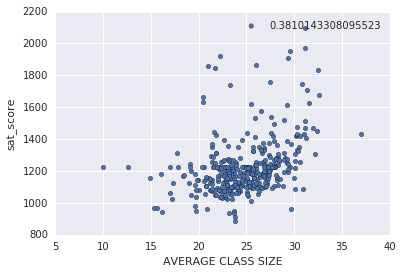

In [92]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score',label=correlations['AVERAGE CLASS SIZE'])
plt.show()

It also seems that there's a positive and pretty strong correlation between the average size of classes and the sat scores (testified also by r=0.38) but the linear trend seems to start with classes that have at least ~20-22 students and with a sat score ~1100.

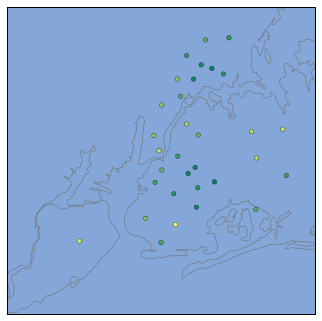

In [61]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='f'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=grouped_districts['lon'].tolist()
latitudes=grouped_districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True,c=grouped_districts['sat_score'],cmap='summer')
plt.show()

From the last plot it seems evident that schools with better sat scores are mainly in Queens, Manhattan and Staten Island, while in the Bronx and in Brooklyn the sat scores keep being pretty low, with a couple of exceptions but only in Brooklyn.

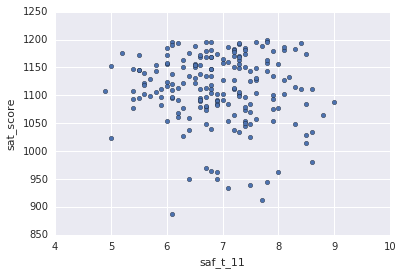

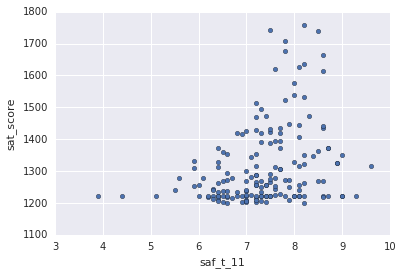

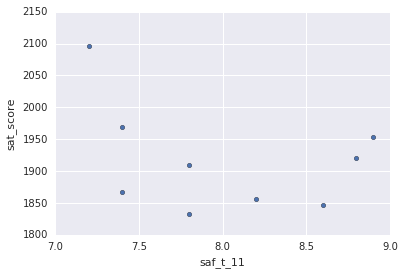

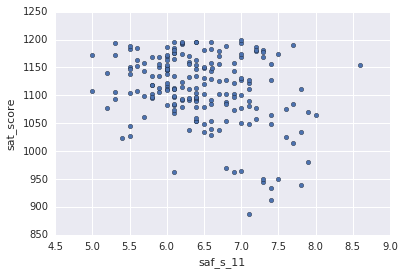

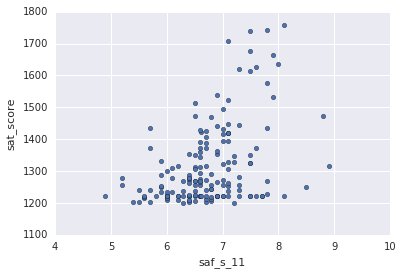

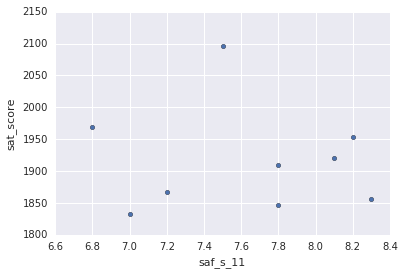

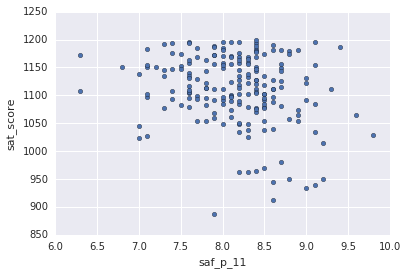

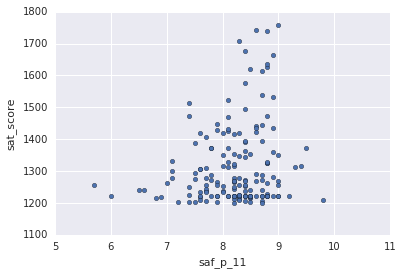

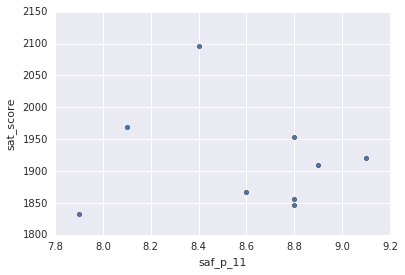

In [93]:
low_scores=combined[combined['sat_score']<1200]
med_scores=combined[(combined['sat_score']>1200)&(combined['sat_score']<1800)]
high_scores=combined[combined['sat_score']>1800]

# Teachers' satisfaction

low_scores.plot.scatter(x='saf_t_11',y='sat_score')
med_scores.plot.scatter(x='saf_t_11',y='sat_score')
high_scores.plot.scatter(x='saf_t_11',y='sat_score')

# Students' satisfaction

low_scores.plot.scatter(x='saf_s_11',y='sat_score')
med_scores.plot.scatter(x='saf_s_11',y='sat_score')
high_scores.plot.scatter(x='saf_s_11',y='sat_score')


# Parents' satisfaction

low_scores.plot.scatter(x='saf_p_11',y='sat_score')
med_scores.plot.scatter(x='saf_p_11',y='sat_score')
high_scores.plot.scatter(x='saf_p_11',y='sat_score')

plt.show()

The correlations between the teachers', students' and parents' satisfactions and the sat scores show a similar pattern with some exceptions. The most particular case is represented by the teachers' answers to the survey. Infact if the trends for students and parents seem pretty similar (a weak negative corr for scores below 1200, a stronger positive corr for scores beween 1200 and 1800 and a weaker positive corr for scores above 1800) the teacher's one is peculiar especially for the highest scores. Infact if, for scores below 1800, the teachers' satisfaction reflects the parents' and students' one, for scores above 1800 the correlation is not even liear but curve.

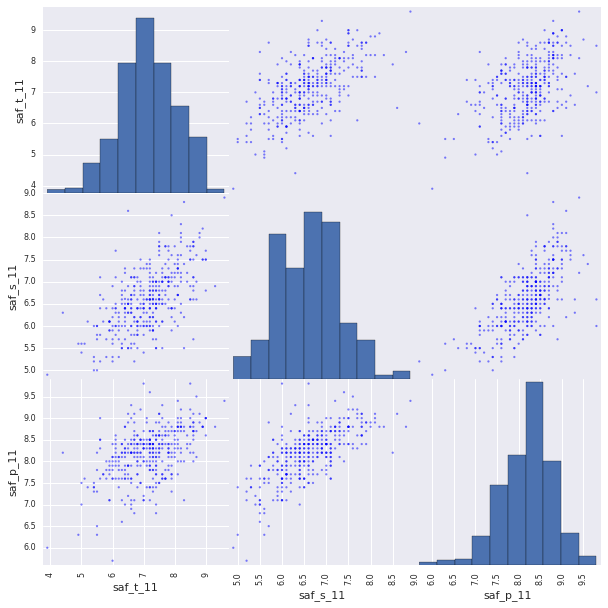

In [96]:
from pandas.plotting import scatter_matrix
scatter_matrix(combined[['saf_t_11','saf_s_11','saf_p_11']],figsize=(10,10))
plt.show()

It seems clear that students' and parents' satisfactions are pretty similar, strong positive correlation. The correlation between teachers-parents and teachers-students are still positive but a little weaker.
Moreover while the majority of teachers and parents have expressed a satisfaction mark of, respectively, 7 and 8.5. The students have expressed a broader range of satisfaction values [5.5-7.5].

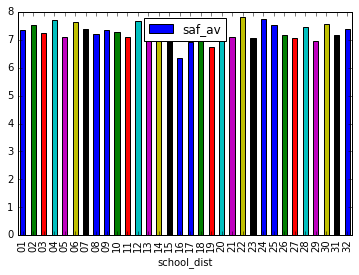

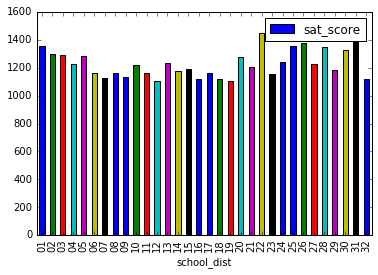

In [15]:
#combined['sat_av']=(combined['saf_t_11']+combined['saf_s_11']+combined['saf_p_11'])/3
#combined.plot.bar(x='DBN',y='sat_av')




grouped_districts['saf_av']=(grouped_districts['saf_t_11']+grouped_districts['saf_s_11']+grouped_districts['saf_p_11'])/3
grouped_districts=grouped_districts.sort_values('school_dist')
grouped_districts.plot.bar(x='school_dist',y='saf_av')
grouped_districts.plot.bar(x='school_dist',y='sat_score')

plt.show()
